# Simple Perception Stack For Self-Driving Cars

![Logo](./logo.png)

**Kareim Tarek AbdelAzeem Amin         1701002**

https://github.com/KareimGazer/Perception-Stack

# Abstract
In this first part of the project we aim to detect and draw the lane line. the frames of the video pass through a pipleline to get processed and achieve the required results. In the following sections we demonstrate those steps.

# Methodology

## Lane Detection
to achieve that the video frame pass through the following steps of the pipeline

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# prototype
the following snippets of code demonstrate the pipleline on images. for videos please run `run.sh` in terminal or see the last two code cells.

## Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
%matplotlib inline

## Camera Calibration
Cameras needed to be calibrated first to remove distortion. we import `calibrate_camera` module and compute correction matrix and distortion coefficients on provided chessboard images in camera_cal folder.

In [ ]:
import calibrate_camera # calibration module
mtx, dist = calibrate_camera.calibrate(9, 6, 'camera_cal/*.jpg')

In [ ]:
mtx, dist

after we got the matrix and distortion coefficients we apply them to checkboards images to check the results.
results can be found at `output_images/calibrated_boards/`, and a sample is plotted inline

In [ ]:
import glob
import cv2
import matplotlib.pyplot as plt
images_names = glob.glob('camera_cal/*.jpg')
for index, image_name in enumerate(images_names):
    image = cv2.imread(image_name)
    undistored_image = calibrate_camera.undistort(image, mtx, dist)
    cv2.imwrite('output_images/calibrated_boards/test{}.jpg'.format(index), undistored_image)

cal_board = plt.imread('output_images/calibrated_boards/test0.jpg')
plt.imshow(cal_board)

we save the results in a pickle dictionary so we don't need to repeat the pipeline and gain performance improvements

In [ ]:
import pickle
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

## Undistort
Now we try to correct the road Images.

In [ ]:
import glob
import cv2
import matplotlib.pyplot as plt
images_names = glob.glob('test_images/*.jpg')
for index, image_name in enumerate(images_names):
    image = cv2.imread(image_name)
    undistorted_image = calibrate_camera.undistort(image, mtx, dist)
    cv2.imwrite('output_images/calibrated_roads/road{}.jpg'.format(index), undistorted_image)

undist_road = plt.imread('output_images/calibrated_roads/road0.jpg')
plt.imshow(undist_road)

## Use color transforms, gradients, etc., to create a thresholded binary image.

I used combination of the B channel In LAB color representation anded with S channel in HLS representation to detect the left yellow lane, and the L channel in the HLS color representation to detect white right lanes.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import sobel # sobel module reads images in RGB using matplot lib
images_names = glob.glob('output_images/calibrated_roads/*.jpg')
ksize = 3
for index, image_name in enumerate(images_names):
    image = cv2.imread(image_name)
    combined_binary = sobel.get_binary(image, ksize)
    plt.imsave('output_images/roads_binary/{}.jpg'.format(index), combined_binary,
               cmap='gray')
thresh_road = plt.imread('output_images/roads_binary/0.jpg')
plt.imshow(thresh_road)

## Apply a perspective transform to rectify binary image ("birds-eye view").

the code is in `bird_view.py` file and I used these points [[530, 490], [750, 490], [210, 690], [1080, 690]]
it only contains one function responsible for the transformation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import bird_view
import lanes
import cv2
import rad

images_names = glob.glob('output_images/roads_binary/*.jpg')
# undists = glob.glob('output_images/calibrated_roads/*.jpg')
for index, image_name in enumerate(images_names):
    image = mpimg.imread(image_name)
    binary_warped, matrix, matrix_inv = bird_view.get_bird_view(image)
    plt.imsave('output_images/roads_view/{}.jpg'.format(index), binary_warped,
               cmap='gray')
thresh_road = plt.imread('output_images/roads_view/0.jpg')
plt.imshow(thresh_road)

## Detect lane pixels and fit to find the lane boundary.
I used the sliding window methodolgy as follows:
- get the indicies of the lanes using histogram to detect the place of max intensities
- create a window and if the number of pixels in it is large get the mean of these pixels and move the window accordingly
- repeat the steps until the frame is full of windows

the minimum number of pixels, window size, and number of windows are all hyper parameters

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import bird_view
import lanes
import cv2
import rad

images_names = glob.glob('output_images/roads_view/*.jpg')
for index, image_name in enumerate(images_names):
    image = mpimg.imread(image_name)
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    out_img, left_fitx, right_fitx, ploty = lanes.fit_polynomial(image_gray)
    plt.imsave('output_images/roads_plt/{}.jpg'.format(index), out_img)
plt_road = plt.imread('output_images/roads_plt/0.jpg')
plt.imshow(plt_road)

## Output visual display of the lane boundaries
after extracting warped binary image and fitting a polynomical to the pixels detected by the previous windows, we use these lines to draw and shade the space between the lanes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import bird_view
import lanes
import cv2
import rad

images_names = glob.glob('output_images/roads_binary/*.jpg')
undists = glob.glob('output_images/calibrated_roads/*.jpg')

for index, image_name in enumerate(images_names):
    image = mpimg.imread(image_name)
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    binary_warped, matrix, matrix_inv = bird_view.get_bird_view(image_gray)
    out_img, left_fitx, right_fitx, ploty = lanes.fit_polynomial(binary_warped)
    
    undist = plt.imread(undists[index])
    result = lanes.draw_path(binary_warped, left_fitx, right_fitx, ploty, matrix_inv, undist)
    
    left_curverad, right_curverad, offset = rad.measure_curvature_real(binary_warped, left_fitx, right_fitx, ploty)
    
    print("{}: curvature ({} m, {} m), offset = {} m".format(index, left_curverad, right_curverad, offset))
    plt.imsave('output_images/roads_maped/{}.jpg'.format(index), result)
plt_road = plt.imread('output_images/roads_maped/0.jpg')
plt.imshow(plt_road)

## pipeline prototype
the pipeline in one function

In [ ]:
import bird_view
import lanes
import rad
import sobel

prev_out_img, prev_left_fitx, prev_right_fitx, prev_ploty = (None, None, None, None)

def pipeline(frame, mtx, dist):
    global prev_out_img, prev_left_fitx, prev_right_fitx, prev_ploty
    undistored_image = calibrate_camera.undistort(frame, mtx, dist)
    # image_rgb = cv2.cvtColor(undistored_image, cv2.COLOR_BGR2RGB)
    combined_soble = sobel.get_binary(undistored_image, ksize)
    # return combined_soble

    binary_warped, matrix, matrix_inv = bird_view.get_bird_view(combined_soble)
    
    out_img, left_fitx, right_fitx, ploty = (None, None, None, None)
    try:
        out_img, left_fitx, right_fitx, ploty = lanes.fit_polynomial(binary_warped, 10, 90, 50)
        prev_out_img, prev_left_fitx, prev_right_fitx, prev_ploty = out_img, left_fitx, right_fitx, ploty
    except:
        out_img, left_fitx, right_fitx, ploty = prev_out_img, prev_left_fitx, prev_right_fitx, prev_ploty
    
    result = lanes.draw_path(binary_warped, left_fitx, right_fitx, ploty, matrix_inv, frame)
    
    # calculating curvature and center offset
    left_curverad, right_curverad, real_offset = rad.measure_curvature_real(binary_warped, left_fitx, right_fitx, ploty)
    curve_info = "radius of curvature ({} Km, {} Km)".format(str(round(left_curverad/1000, 2)), 
                                                           str(round(right_curverad/1000, 2)))
    
    center_info = "offset from center  = {} m".format(str(round(real_offset, 2)))
    
    detailed = cv2.putText(result, curve_info, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0 , 0), 2, cv2.LINE_AA)
    detailed = cv2.putText(detailed, center_info, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0 , 0), 2, cv2.LINE_AA)
    return result

## Live Processing

In [ ]:
import cv2
import numpy as np
import sobel
import calibrate_camera

# Creating a VideoCapture object to read the video
# cap = cv2.VideoCapture('project_video.mp4')
cap = cv2.VideoCapture('challenge_video.mp4')
# cap = cv2.VideoCapture('harder_challenge_video.mp4') 

ksize = 3

# Loop until the end of the video
while (cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = cv2.resize(frame, (1280, 720), fx = 0, fy = 0,
                         interpolation = cv2.INTER_CUBIC)
 
    # Display the resulting frame
    cv2.imshow('Frame', frame)
    result = pipeline(frame, mtx, dist)
    cv2.imshow('gblur', result)

 
    # define q as the exit button
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
 
# release the video capture object
cap.release()

# Closes all the windows currently opened.
cv2.destroyAllWindows()

## store video

In [ ]:
import numpy as np
import cv2

ksize = 3

# cap = cv2.VideoCapture('challenge_video.mp4')
cap = cv2.VideoCapture('project_video.mp4')

video_file = 'race1.mp4'
frame_size = (1280, 720)
fps = 40
out = cv2.VideoWriter(video_file, cv2.VideoWriter_fourcc(*'MP4V'), fps, frame_size)

# Loop until the end of the video
while (cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = cv2.resize(frame, frame_size, fx = 0, fy = 0,
                         interpolation = cv2.INTER_CUBIC)
 
    # Display the resulting frame
    cv2.imshow('Frame', frame)
    result = pipeline(frame, mtx, dist)
    cv2.imshow('image', result)
    # result_bgr = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    out.write(result)

    # define q as the exit button
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release the video capture object
cap.release()
out.release()
# Closes all the windows currently opened.
cv2.destroyAllWindows()

# Discussion
The pipeline could benefit from mergeing multiple detection techniques like anding the color channels with the gradients obtained from sobel for example to get robust lines. also the use of adaptive thresholding, and contrast equilization could improve the performance, though I didn't much difference from applying them.

## Cars Detection (YOLO)
I used (YOLO) "You Only Look Once" because it is a popular algorithm because it achieves high accuracy while also being able to run in real time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

## Importing some libs

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

### load yolo weights and config

In [ ]:
weights_path = 'model_data/yolov3.weights'
confg_path = 'model_data/yolov3.cfg'
labels_path = 'model_data/coco.names'
labels = open(labels_path).read().strip().split('\n')
# labels

### load the NN in CV

In [ ]:
net = cv2.dnn.readNetFromDarknet(confg_path, weights_path)

### Getting A Test Image

In [ ]:
test_image = plt.imread('test_images/test4.jpg')
plt.imshow(test_image)

In [ ]:
image_height, image_width = test_image.shape[:2]
image_height, image_width

### Output Layers Names

In [ ]:
out_layer_name = net.getUnconnectedOutLayersNames()
out_layer_name

### Run inference on test image

In [ ]:
blob = cv2.dnn.blobFromImage(test_image, 1/255.0, (256, 256), crop=False, swapRB=False) # check RB, 1/255.0
net.setInput(blob)
%time net_out = net.forward(out_layer_name)

I used small image size to trade off accuray for speed
#### We can see that the forward path took relativly short time on CPU

### Detecting Objects In The Image

In [ ]:
boxes = []
confidences = []
classIDs = []
for output in net_out:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if(confidence > .9):
            box = detection[:4] * np.array([image_width, image_height, image_width, image_height])
            bx, by, bw, bh = box.astype('int')
            x, y = int(bx - (bw/2)), int(by - bh/2)
            boxes.append([x, y, int(bw), int(bh)])
            confidences.append(float(confidence))
            classIDs.append(classID)

In [ ]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.8, 0.8)

In [ ]:
for i in idxs.flatten():
    x, y = [boxes[i][0], boxes[i][1]]
    w, h = [boxes[i][2], boxes[i][3]]
    cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 255),2)
    cv2.putText(test_image, '{}:{:.2f}'.format(labels[classIDs[i]], confidences[i]), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 139,  139), 2)
    
plt.imshow(test_image)

## Cars Detection (HOG)

In This section I provide the classic method of car detection using HOG (histogram of oriented gradients) at the preprocessing phase to extract features, and then use a linear svm for performance and speed of operation while achieving good results

### Methodology
- crop the image to the region of interest (ROI) "the lower half of the image"
- extract the hod features for the whole region
- decide a suitable window size and slide it along the image
- store the corners of these windows that found a car
- draw a heat map of these windows
- taking a threshold of the heat map to get a better measurement
- average the windows locations along many frame to reduce the noise
- draw the results

#### Importing libs

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from lesson_functions import *

#### loading the model data

In [2]:
import pickle
file_name = "svc_pickle.p"
# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load(open(file_name, "rb" ))

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]

#### Then we draw all squares that found a car

CPU times: total: 422 ms
Wall time: 452 ms


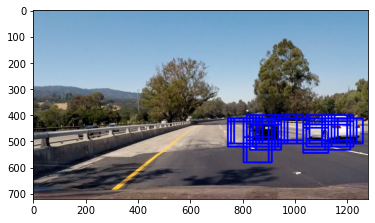

In [5]:
image = mpimg.imread('test_images/test4.jpg')
# image = mpimg.imread('BasicVideo/test_image50.jpg')
# image = mpimg.imread('ChallangeVideo/test_image5.jpg')
ystart = 400 # 330 650
ystop = 656
scale = 1.5
move_pix = 1 # 1
# spatial_size = 32
# hist_bins = 32
%time out_img, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, move_pix)
plt.imshow(out_img)

#### The Heat Map

Text(0.5, 1.0, 'Heat Map')

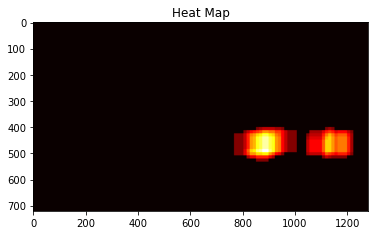

In [12]:
# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')

#### The boxes after thresholding and averaging

Text(0.5, 1.0, 'Car Positions')

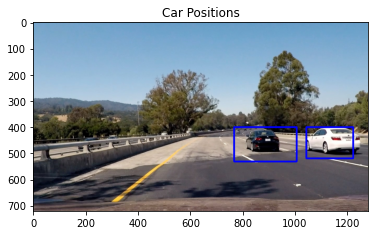

In [13]:
plt.imshow(draw_img)
plt.title('Car Positions')

# Discussion
modern car detection methods using neural nets like YOLO proved best. though, the classic method was the state of the art with not bad performance before the new methods emerge.

classic methods were the inception of the new ones using concepts like sliding windows, IOU (Intersection Of Union), and NMS (Non-Maximum Supression).

using sliding windows with different sizes can lead to better accuracy for SVM + Hog but lower performance.